In [1]:
import numpy as np
import pandas as pd
import cv2

import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras import Sequential
from tensorflow.keras.layers import *
from tensorflow.keras.preprocessing.image import ImageDataGenerator

import warnings
warnings.filterwarnings('ignore')
import os
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from keras.preprocessing import image
from keras.layers import *
from keras.models import Sequential
from keras.applications.resnet50 import ResNet50
from keras.models import Model

2024-11-13 19:32:03.930335: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-11-13 19:32:03.938944: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-11-13 19:32:03.948876: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-11-13 19:32:03.951780: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-11-13 19:32:03.959832: I tensorflow/core/platform/cpu_feature_guar

In [2]:
train_dir = "archive/train/"
test_dir = "archive/test"
valid_dir ='archive/valid'

Found 0 images in directory: archive/train/
Found 1569 images in directory: archive/train/0
Found 803 images in directory: archive/train/1


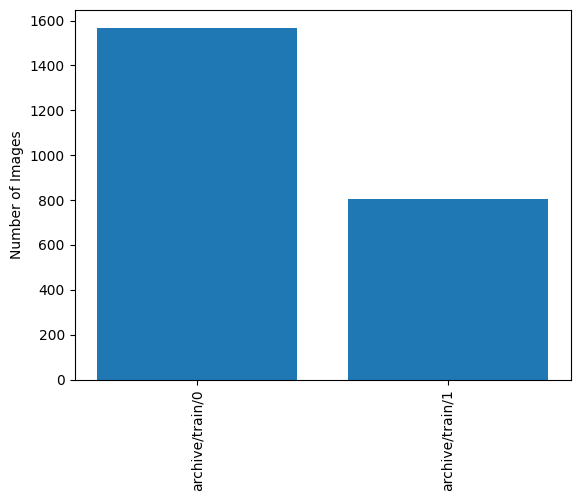

In [3]:
num_images = 0

for dirpath, dirnames, filenames in os.walk(train_dir):
    for filename in filenames:
        if filename.lower().endswith(('.jpg')):
            num_images += 1

    print(f"Found {num_images} images in directory: {dirpath}")
    num_images = 0


subdirectories = [os.path.join(train_dir, d) for d in os.listdir(train_dir) if os.path.isdir(os.path.join(train_dir, d))]

# Count the number of images in each subdirectory
counts = [0] * len(subdirectories)
for i, directory in enumerate(subdirectories):
    counts[i] = len(os.listdir(directory))

# Create a bar chart to visualize the distribution
plt.bar(subdirectories, counts)
plt.xticks(rotation=90)
plt.ylabel("Number of Images")
plt.show()

In [4]:
minority_train_gen = tf.keras.preprocessing.image.ImageDataGenerator(
        preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input,
        validation_split=0.2,
        rotation_range=10,
        brightness_range=(0,10),
        width_shift_range=0.05,
        height_shift_range=0.05,
        zoom_range=0.05,
        horizontal_flip=True,
        fill_mode='nearest',

)

main_train_gen = ImageDataGenerator(rescale=1./255)

test_gen = tf.keras.preprocessing.image.ImageDataGenerator(
        preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input
)

In [5]:
minority_class_directory = 'archive/train/1'

minority_class_generator = minority_train_gen.flow_from_directory(
    directory=minority_class_directory,
    target_size=(320,320),
    batch_size=20,
    class_mode='binary',
    shuffle=True,
)

main_generator = main_train_gen.flow_from_directory(
    directory=train_dir,
    target_size=(320, 320),
    batch_size=20,
    class_mode='binary',
    shuffle=True,
)

Found 0 images belonging to 0 classes.
Found 2372 images belonging to 2 classes.


In [6]:
"""
train_images = train_gen.flow_from_directory(
        directory=train_dir,
        target_size=(320,320),
        batch_size=20,
        shuffle=True,
        seed=42,
)
"""
val_images = main_train_gen.flow_from_directory(
        directory=valid_dir,
        target_size=(320,320),
        class_mode='binary',
        shuffle=True,
)
test_images = test_gen.flow_from_directory(
        directory=test_dir,
        target_size=(320,320),
        class_mode='binary',
        batch_size=1,
        shuffle=False,
)

Found 675 images belonging to 2 classes.
Found 336 images belonging to 2 classes.


Counter({0: 1569, 1: 803})


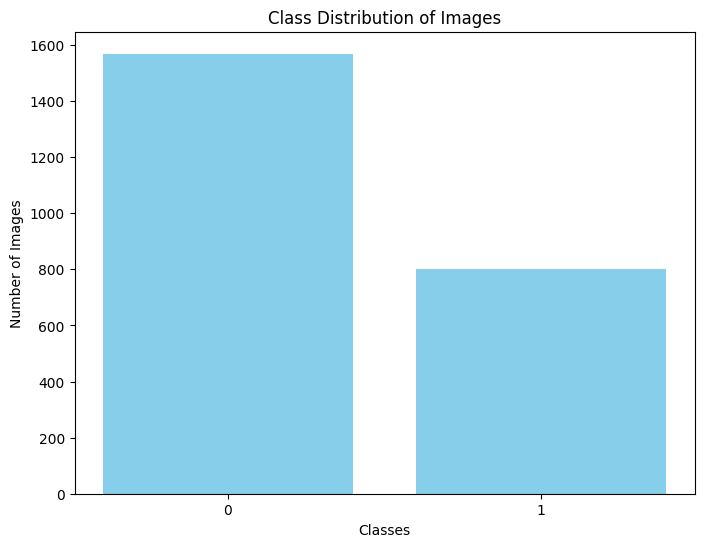

In [7]:
from collections import Counter
class_counts = Counter(main_generator.classes)
print(class_counts)

class_labels = list(main_generator.class_indices.keys())
class_values = [class_counts[i] for i in range(len(class_labels))]

# Plotting the bar graph
plt.figure(figsize=(8, 6))
plt.bar(class_labels, class_values, color='skyblue')
plt.xlabel('Classes')
plt.ylabel('Number of Images')
plt.title('Class Distribution of Images')
plt.show()

In [8]:
class_names = os.listdir('archive/train')
print(f"Class names: {class_names}")

Class names: ['0', '1']


In [9]:
images, labels = next(val_images)

print("Shape of images: ", images.shape)
print("Labels", labels.shape)

Shape of images:  (32, 320, 320, 3)
Labels (32,)


Text(0.5, 1.0, '1')

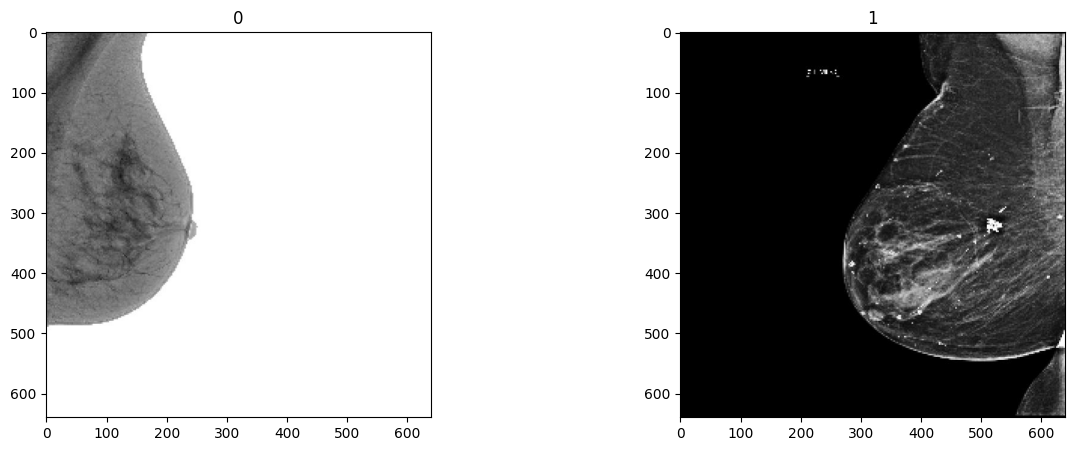

In [10]:
plt.figure(1, figsize = (15 , 5))
plt.subplot(1, 2 , 1)
plt.imshow(cv2.imread('archive/train/0/105_1232990271_png.rf.0d15468a4bec2ad2147f0616b6821681.jpg'))
plt.title('0')



plt.figure(1, figsize = (15 , 5))
plt.subplot(1, 2 , 2)
plt.imshow(cv2.imread('archive/train/1/10130_1672636630_png.rf.52c6d1c8c6c58c5c1c5fcaaf57feb81d.jpg'))
plt.title('1')


In [11]:
pretrained_model = tf.keras.applications.ResNet101(
    input_shape=(320, 320, 3),
    include_top=False,
    weights='imagenet',
    pooling='max'
)
pretrained_model.trainable = False


inputs = pretrained_model.input

layer1 = tf.keras.layers.Dense(1024, activation='relu')(pretrained_model.output)
layer2 = tf.keras.layers.BatchNormalization()(layer1)
layer3 = tf.keras.layers.Dropout(0.4)(layer2)

layer4 = tf.keras.layers.Dense(512, activation='relu')(layer3)
layer5 = tf.keras.layers.BatchNormalization()(layer4)
layer6 = tf.keras.layers.Dropout(0.3)(layer5)

layer7 = tf.keras.layers.Dense(256, activation='relu')(layer6)
layer8 = tf.keras.layers.BatchNormalization()(layer7)
layer9 = tf.keras.layers.Dropout(0.2)(layer8)

outputs = tf.keras.layers.Dense(525, activation='softmax')(layer9)
outputs = tf.keras.layers.Dense(1, activation='sigmoid')(outputs)

model = tf.keras.Model(inputs=inputs, outputs=outputs)


I0000 00:00:1731506525.921654 1984151 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1731506525.939866 1984151 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1731506525.942169 1984151 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1731506525.945798 1984151 cuda_executor.cc:1015] successful NUMA node read from SysFS ha

In [12]:
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 320, 320,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 326, 326,  │          0 │ input_layer[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 160, 160,  │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 160, 160,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 160, 160,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 162, 162,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 80, 80,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 80, 80,    │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 80, 80,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 80, 80,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 80, 80,    │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 80, 80,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 80, 80,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 80, 80,    │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 80, 80,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 80, 80,    │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, 80, 80,    │      1,024 │ conv2_block1_3_c

 Total params: 45,555,099 (173.78 MB)

 Trainable params: 2,893,339 (11.04 MB)

 Non-trainable params: 42,661,760 (162.74 MB)

In [13]:
model.compile(optimizer = 'adam',
              loss = 'binary_crossentropy',
              metrics = ['accuracy'])

In [76]:
def balanced_generator(main_gen, minority_gen):
    while True:
        main_images, main_labels = next(main_gen)
        
        minority_images, minority_labels = next(minority_gen)
        
        combined_images = np.concatenate((main_images, minority_images), axis=0)
        combined_labels = np.concatenate((main_labels, minority_labels), axis=0)
        
        yield combined_images, combined_labels

history = model.fit(
    balanced_generator(main_generator, minority_class_generator),
    validation_data=val_images,
    epochs=5,
    steps_per_epoch=400,    # Adjust this based on your dataset size

)

Epoch 1/5
400/400 ━━━━━━━━━━━━━━━━━━━━ 68s 169ms/step - accuracy: 0.7586 - loss: 0.5370 - val_accuracy: 0.6637 - val_loss: 0.7101
Epoch 2/5
400/400 ━━━━━━━━━━━━━━━━━━━━ 68s 169ms/step - accuracy: 0.7652 - loss: 0.5241 - val_accuracy: 0.6474 - val_loss: 0.6580
Epoch 3/5
400/400 ━━━━━━━━━━━━━━━━━━━━ 68s 170ms/step - accuracy: 0.7637 - loss: 0.5214 - val_accuracy: 0.5719 - val_loss: 0.7344
Epoch 4/5
400/400 ━━━━━━━━━━━━━━━━━━━━ 68s 169ms/step - accuracy: 0.7820 - loss: 0.4963 - val_accuracy: 0.6652 - val_loss: 0.7364
Epoch 5/5
400/400 ━━━━━━━━━━━━━━━━━━━━ 68s 169ms/step - accuracy: 0.7777 - loss: 0.5064 - val_accuracy: 0.6741 - val_loss: 0.7016


In [77]:
"""history = model.fit(
    train_images,
    validation_data=val_images,
    epochs=200,
    class_weight={0:3, 1:1},
    callbacks=[
        tf.keras.callbacks.EarlyStopping(
            monitor='val_loss',
            patience=12,
            restore_best_weights=True
        )
    ]
)"""

"history = model.fit(\n    train_images,\n    validation_data=val_images,\n    epochs=200,\n    class_weight={0:3, 1:1},\n    callbacks=[\n        tf.keras.callbacks.EarlyStopping(\n            monitor='val_loss',\n            patience=12,\n            restore_best_weights=True\n        )\n    ]\n)"

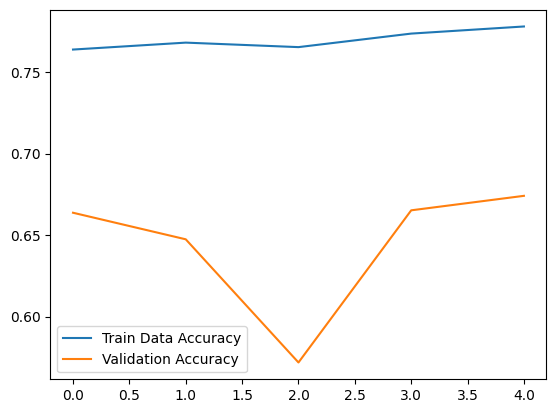

In [78]:
plt.plot(history.history['accuracy'], label = 'Train Data Accuracy')
plt.plot(history.history['val_accuracy'], label = 'Validation Accuracy')
plt.legend()
plt.show()

In [79]:
test_loss, test_accuracy = model.evaluate(test_images)
print(f'Test accuracy: {test_accuracy}')

336/336 ━━━━━━━━━━━━━━━━━━━━ 6s 19ms/step - accuracy: 0.5317 - loss: 0.7672
Test accuracy: 0.5297619104385376


In [80]:
model.save('transfer_resnet.keras')

In [81]:
model.predict(test_images)


336/336 ━━━━━━━━━━━━━━━━━━━━ 6s 18ms/step


array([[0.12393712],
       [0.74457055],
       [0.74456793],
       [0.7445663 ],
       [0.12398859],
       [0.74456996],
       [0.74456984],
       [0.12393712],
       [0.74457055],
       [0.12393712],
       [0.7445656 ],
       [0.12393712],
       [0.12393712],
       [0.74457055],
       [0.74452436],
       [0.74457055],
       [0.12393712],
       [0.7445702 ],
       [0.74457055],
       [0.12393712],
       [0.74455154],
       [0.12393712],
       [0.36228275],
       [0.74457055],
       [0.12393712],
       [0.12393712],
       [0.12393712],
       [0.4007127 ],
       [0.36160406],
       [0.64299744],
       [0.72399986],
       [0.12393712],
       [0.38668734],
       [0.74456847],
       [0.12393712],
       [0.73622024],
       [0.7378821 ],
       [0.12393712],
       [0.74455464],
       [0.12393712],
       [0.36228245],
       [0.74456984],
       [0.74456793],
       [0.7445644 ],
       [0.7444708 ],
       [0.12825483],
       [0.38194662],
       [0.743

In [82]:
predictions = (model.predict(test_images) > 0.38).astype(int).flatten()
print(predictions)

336/336 ━━━━━━━━━━━━━━━━━━━━ 6s 18ms/step
[0 1 1 1 0 1 1 0 1 0 1 0 0 1 1 1 0 1 1 0 1 0 0 1 0 0 0 1 0 1 1 0 1 1 0 1 1
 0 1 0 0 1 1 1 1 0 1 1 0 0 1 0 1 1 0 0 1 0 1 1 1 1 1 0 0 0 0 0 0 0 1 0 1 1
 0 1 0 1 0 0 0 0 1 0 0 0 0 0 0 1 0 1 0 1 1 1 0 1 0 1 0 0 1 1 0 0 0 0 0 1 0
 1 1 1 1 1 0 1 1 1 0 0 1 0 1 1 1 0 0 1 1 1 0 1 1 0 0 1 1 1 1 0 0 0 1 0 0 1
 0 0 0 0 0 1 1 1 0 1 0 0 0 0 1 0 0 0 1 1 1 0 0 1 0 0 0 1 1 1 0 0 0 0 0 1 1
 0 0 0 0 1 0 0 0 0 1 1 1 1 0 1 1 1 1 0 1 1 1 0 0 1 1 1 1 1 1 1 1 0 0 1 1 0
 1 0 0 0 0 0 1 0 0 1 0 0 0 0 1 1 1 1 1 1 1 0 0 1 1 1 1 0 0 0 0 0 1 1 1 1 1
 0 0 1 1 1 0 1 1 1 0 1 1 0 1 1 0 1 0 1 1 0 0 0 0 1 0 1 0 0 1 0 1 1 1 0 0 0
 1 1 0 1 0 0 1 1 0 0 1 1 0 0 1 0 0 0 0 1 1 0 1 1 1 1 1 1 1 1 0 1 0 0 0 0 1
 1 1 0]


In [83]:
from sklearn.metrics import accuracy_score, classification_report
from sklearn.metrics import f1_score
import seaborn as sns

In [86]:
CLASS_NAMES = list(main_generator.class_indices.keys())
predictions = (model.predict(test_images) > 0.5).astype(int).flatten()
acc = accuracy_score(test_images.labels, predictions)
cm = tf.math.confusion_matrix(test_images.labels, predictions).numpy()
clr = classification_report(test_images.labels, predictions, target_names=CLASS_NAMES)

print("Test Accuracy: {:.3f}%".format(acc * 100))

336/336 ━━━━━━━━━━━━━━━━━━━━ 6s 17ms/step
Test Accuracy: 52.976%


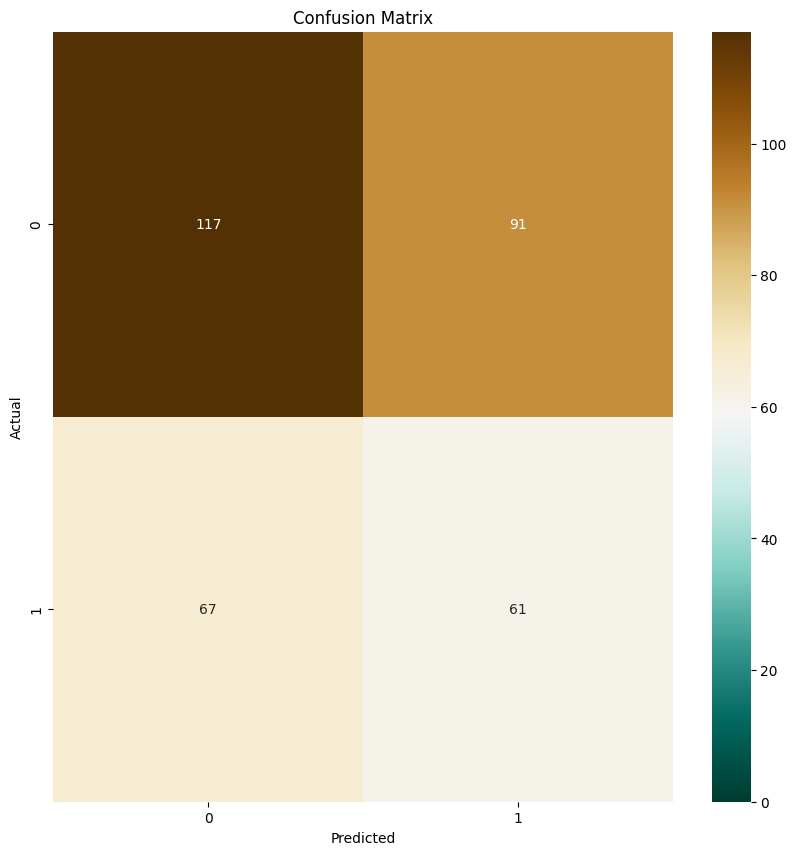

In [87]:
plt.figure(figsize=(10, 10))
sns.heatmap(cm, annot=True,fmt='d', vmin=0, cmap='BrBG_r', cbar=True)
plt.xticks(ticks= np.arange(2) + 0.5,)
plt.yticks(ticks= np.arange(2) + 0.5)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()